In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import SVG
import keras
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras import backend as K
from sklearn.model_selection import train_test_split

K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [2]:
ratings = pd.read_csv('ml-latest-small/ratings.csv')
movies = pd.read_csv('ml-latest-small/movies.csv')

#ratings = pd.read_csv('ml-20m/ratings.csv')
#movies = pd.read_csv('ml-20m/movies.csv')
#print(movies.head())

ratings = pd.merge(ratings, movies, on='movieId')

ratings.userId = ratings.userId.astype('category').cat.codes.values
ratings.movieId = ratings.movieId.astype('category').cat.codes.values
print(ratings.head())

   userId  movieId  rating   timestamp             title  \
0       0        0     4.0   964982703  Toy Story (1995)   
1       4        0     4.0   847434962  Toy Story (1995)   
2       6        0     4.5  1106635946  Toy Story (1995)   
3      14        0     2.5  1510577970  Toy Story (1995)   
4      16        0     4.5  1305696483  Toy Story (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1  Adventure|Animation|Children|Comedy|Fantasy  
2  Adventure|Animation|Children|Comedy|Fantasy  
3  Adventure|Animation|Children|Comedy|Fantasy  
4  Adventure|Animation|Children|Comedy|Fantasy  


Dataset split

In [3]:
n_users, n_movies = len(ratings['userId'].unique()), len(ratings['movieId'].unique())
print("Number of users:",n_users)
print("Number of movies:",n_movies)


train, test = train_test_split(ratings, test_size=0.05)
print("Number of rows in test data set:", (len(test)))
print("Number of rows in training data set:",(len(train)))

Number of users: 610
Number of movies: 9724
Number of rows in test data set: 5042
Number of rows in training data set: 95794


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


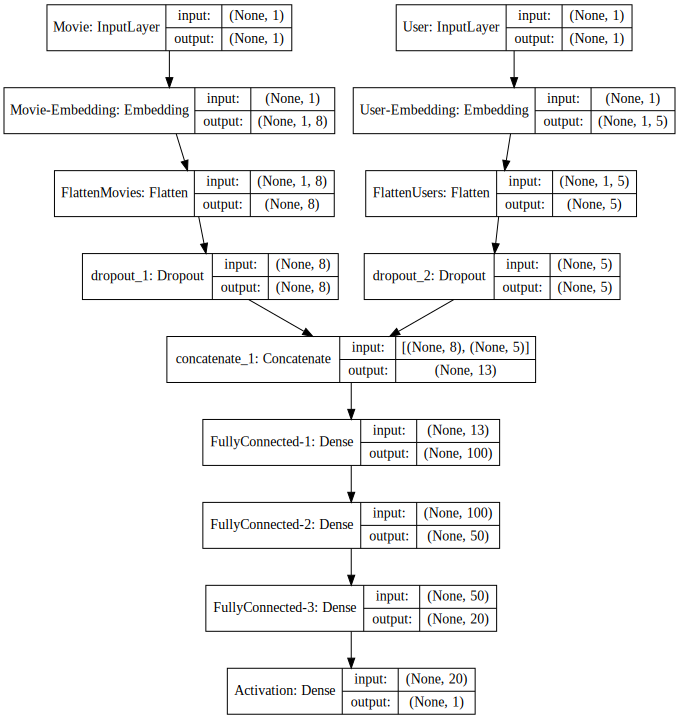

In [4]:
n_latent_factors_user = 5
n_latent_factors_movie = 8

movie_input = keras.layers.Input(shape=[1],name='Movie')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors_movie, name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)
movie_vec = keras.layers.Dropout(0.5)(movie_vec)


user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors_user,name='User-Embedding')(user_input))
user_vec = keras.layers.Dropout(0.5)(user_vec)


concat = keras.layers.concatenate([movie_vec, user_vec])
concat_dropout = keras.layers.Dropout(0.2)(concat)
dense = keras.layers.Dense(200,name='FullyConnected')(concat)
dropout_1 = keras.layers.Dropout(0.2,name='Dropout')(dense)
dense_2 = keras.layers.Dense(100,name='FullyConnected-1')(concat)
dropout_2 = keras.layers.Dropout(0.2,name='Dropout')(dense_2)
dense_3 = keras.layers.Dense(50,name='FullyConnected-2')(dense_2)
dropout_3 = keras.layers.Dropout(0.2,name='Dropout')(dense_3)
dense_4 = keras.layers.Dense(20,name='FullyConnected-3', activation='relu')(dense_3)


result = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)
model = keras.Model([user_input, movie_input], result)
model.compile(optimizer=Adam(lr=0.001),loss= 'mean_absolute_error')

#visualize model
SVG(model_to_dot(model,  show_shapes=True, rankdir='HB').create(prog='dot', format='svg'))

Instructions for updating:
Use tf.cast instead.


Text(0, 0.5, 'Train Error')

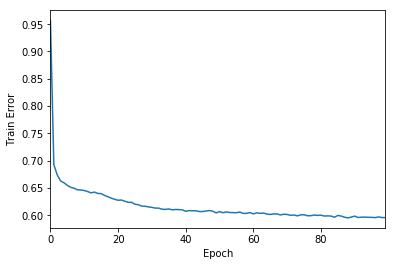

In [5]:
history = model.fit([train['userId'], train['movieId']], train.rating,batch_size=256, epochs=100, verbose=0)
pd.Series(history.history['loss']).plot()
plt.xlabel("Epoch")
plt.ylabel("Train Error")
#model.save_weights('neural-weights.h5')

In [6]:
y_hat = model.predict([test.userId, test.movieId])
y_true = test.rating

print("MAE:",mean_absolute_error(y_true,y_hat))
print("RMSE:",sqrt(mean_squared_error(y_true, y_hat)))

MAE: 0.6562822706072352
RMSE: 0.8961293645274964


In [7]:
def addRating(movieName,rating):
    m = ratings.loc[ratings['title']==movieName].movieId
    id = m.unique()
    new_user = [610]
    history = model.fit([new_user, id], [5] , epochs=1, verbose=0)
    # pd.Series(history.history['loss']).plot()
    # plt.xlabel("Epoch")
    # plt.ylabel("Train Error")
    
    new_user = new_user * n_movies
    movieIds = ratings['movieId'].unique()
    preds = model.predict([new_user, movieIds])
    
    
    preds = pd.DataFrame(data=preds)
    movieIds = pd.DataFrame(data=movieIds)

    
    preds2 = preds.merge(movieIds,left_index=True,right_index=True)
    preds2.columns= ['rating','movieId']
    
    preds2 = preds2.sort_values(by='rating', ascending=False)

    return preds2.merge(ratings[['movieId','title','genres']], on='movieId').drop_duplicates()

In [8]:
preds = addRating("Lord of the Rings: The Fellowship of the Ring, The (2001)",5)
print(preds.head())

     rating  movieId                           title  \
0  5.157592     8943                  Villain (1971)   
1  5.108462     5423       Unfaithfully Yours (1948)   
2  5.041214     7347           Enter the Void (2009)   
4  5.040060     8708  The Fox and the Hound 2 (2006)   
5  5.038970     5128           Little Murders (1971)   

                                genres  
0                 Crime|Drama|Thriller  
1                               Comedy  
2                                Drama  
4  Adventure|Animation|Children|Comedy  
5                         Comedy|Crime  
